In [2]:
import time
import serial
import matplotlib.pyplot as plt

In [3]:
!python -m serial.tools.list_ports

/dev/ttyACM0        
/dev/ttyUSB0        
2 ports found


In [8]:
import minimalmodbus

# Setting up the Modbus RTU connection
instrument = minimalmodbus.Instrument('/dev/ttyUSB0', 1)
instrument.serial.baudrate = 115200
instrument.serial.parity = minimalmodbus.serial.PARITY_NONE
instrument.mode = minimalmodbus.MODE_RTU

# Reading 12 registers starting from 2560 (0x0A00 in hex), which equals 24 bytes
response = instrument.read_registers(2560, 12, functioncode=3)

# Extracting the 6 quantities from the response. Each quantity is made up of 2 registers (4 bytes).
quantities = [(response[i] << 16) | response[i+1] for i in range(0, len(response), 2)]

print(quantities)


[214, 105, 4294966390, 1323, 220, 4294966754]


In [33]:
import serial
port = "/dev/ttyUSB0"
# Initialize serial connection
ser = serial.Serial(port=port, baudrate=115200, bytesize=8, parity='N', stopbits=1, timeout=3)

# Modbus-RTU command
command =b'\x01\x03\t\xff\x00\x0cvc'# bytes.fromhex("01 03 ff 00 0c vc")

ser.write(command)
response = ser.read(ser.inWaiting())

# Close the serial connection
ser.close()

# Print or process the response if needed
print(response)

b''


In [132]:
import minimalmodbus

def twos_complement(value, bits):
    """Compute the 2's complement of int value."""
    if value & (1 << (bits - 1)):
        value -= 1 << bits
    return value

# Setting up the Modbus RTU connection
instrument = minimalmodbus.Instrument('/dev/ttyUSB0', 1)
instrument.serial.baudrate = 115200
instrument.serial.parity = minimalmodbus.serial.PARITY_NONE
instrument.mode = minimalmodbus.MODE_RTU

# Reading 12 registers starting from 2560 (0x0A00 in hex), which equals 24 bytes
response = instrument.read_registers(2560, 12, functioncode=3)

# Extracting the 6 quantities from the response. Each quantity is made up of 2 registers (4 bytes).
quantities_raw = [(response[i] << 16) | response[i+1] for i in range(0, len(response), 2)]

# Convert quantities using two's complement if they are negative
quantities = [twos_complement(q, 32) for q in quantities_raw]

print(quantities)


[221, 109, -923, 1641, 250, -579]


In [146]:
import minimalmodbus
import time
import plotly.express as px
import pandas as pd

def twos_complement(value, bits):
    """Compute the 2's complement of int value."""
    if value & (1 << (bits - 1)):
        value -= 1 << bits
    return value

# Setting up the Modbus RTU connection
instrument = minimalmodbus.Instrument('/dev/ttyUSB0', 1)
instrument.serial.baudrate = 115200
instrument.serial.parity = minimalmodbus.serial.PARITY_NONE
instrument.mode = minimalmodbus.MODE_RTU

# Store measurements for each of the 6 sensors
measurements = [[] for _ in range(6)]
time_points = []

end_time = time.time() + 5  # Measure for 5 seconds

while time.time() < end_time:
    # Reading 12 registers starting from 2560 (0x0A00 in hex), which equals 24 bytes
    response = instrument.read_registers(2560, 12, functioncode=3)
    
    # Extracting the 6 quantities from the response and convert using two's complement
    quantities = [twos_complement((response[i] << 16) | response[i+1], 32) for i in range(0, len(response), 2)]
    
    # Append measurements for each sensor
    for q_values, q in zip(measurements, quantities):
        q_values.append(q)
    
    time_points.append(time.time() - (end_time - 5))  # Record the measurement time
    
    time.sleep(0.01)  # Interval of 0.1 seconds

# Convert data to a DataFrame for easy plotting with Plotly Express
labels = ['Fx', 'Fy', 'Fz', 'Mx', 'My', 'Mz']
df = pd.DataFrame({'Time': time_points})
for label, data in zip(labels, measurements):
    df[label] = data

In [148]:

# Plot using Plotly Express
fig = px.line(df, x='Time', y=labels, title="Sensor Measurements over Time")
fig.show()

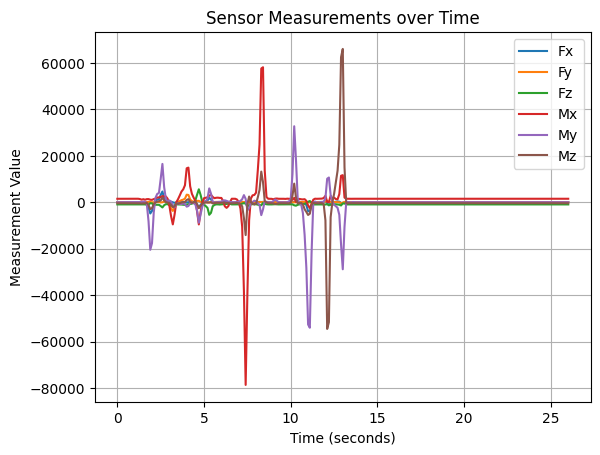

In [602]:
import minimalmodbus
import time
import matplotlib.pyplot as plt

def twos_complement(value, bits):
    """Compute the 2's complement of int value."""
    if value & (1 << (bits - 1)):
        value -= 1 << bits
    return value

# Setting up the Modbus RTU connection
instrument = minimalmodbus.Instrument('/dev/ttyUSB1', 1)
instrument.serial.baudrate = 115200
instrument.serial.parity = minimalmodbus.serial.PARITY_NONE
instrument.mode = minimalmodbus.MODE_RTU

# Store measurements for each of the 6 sensors
measurements = [[] for _ in range(6)]

end_time = time.time() + 30  # Measure for 5 seconds

while time.time() < end_time:
    # Reading 12 registers starting from 2560 (0x0A00 in hex), which equals 24 bytes
    response = instrument.read_registers(2560, 12, functioncode=3)
    
    # Extracting the 6 quantities from the response and convert using two's complement
    quantities = [twos_complement((response[i] << 16) | response[i+1], 32) for i in range(0, len(response), 2)]
    
    # Append measurements for each sensor
    for i, q in enumerate(quantities):
        measurements[i].append(q)
    
    time.sleep(0.1)  # Interval of 0.1 seconds

# Plotting the results
time_points = [0.1 * i for i in range(len(measurements[0]))]
labels = ['Fx', 'Fy', 'Fz', 'Mx', 'My', 'Mz']

for i, data in enumerate(measurements):
    plt.plot(time_points, data, label=labels[i])

plt.title("Sensor Measurements over Time")
plt.xlabel("Time (seconds)")
plt.ylabel("Measurement Value")
plt.legend()
plt.grid(True)
plt.show()


In [219]:
import serial
import time

def calculate_crc(data):
    crc = 0xFFFF
    for byte in data:
        crc ^= byte
        for _ in range(8):
            if crc & 0x0001:
                crc >>= 1
                crc ^= 0xA001
            else:
                crc >>= 1
    return crc.to_bytes(2, byteorder="little")

port = "/dev/ttyUSB1"

# Initialize serial connection
ser = serial.Serial(port=port, baudrate=115200, bytesize=8, parity='N', stopbits=1, timeout=3)

# Modbus-RTU command without CRC
command_without_crc = b'\x01\x03\t\xff\x00\x0c'
crc = calculate_crc(command_without_crc)

command = command_without_crc + crc

ser.write(command)

# Small delay to allow the device to respond. You can adjust this value if needed.
time.sleep(0.1)

# Get the response (you might need to adjust the length according to the expected response size)
response = ser.read(ser.inWaiting())

# Close the serial connection
ser.close()

# Print or process the response if needed
print(response)


b'\x01\x03\x18\x00\x00\x00\x00\x00\x00\x00s\x00\x00\x00e\xff\xff\xfcw\x00\x00\x05\xfb\x00\x00\x0082%'


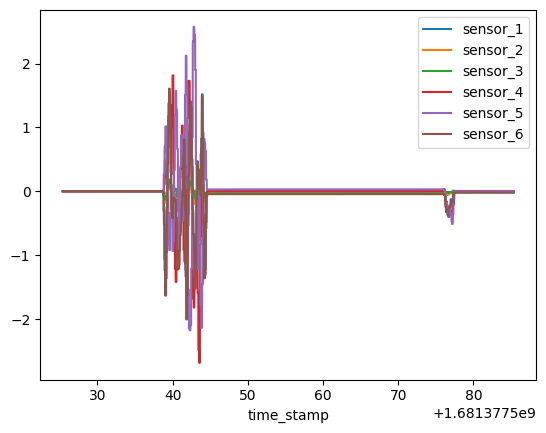

In [13]:
df = read_measurements_df(duration=60)
df.plot(x='time_stamp')
plt.show()